In [24]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os

In [188]:
df = pd.read_csv("combined_energy_data.csv")

## Data Preprocessing

In [189]:
## convert it to datetime
df['datetime'] = pd.to_datetime(df.datetime)

In [190]:
agg_columns =  ["datetime","Wind"]
required_columns = ["Hours"] + agg_columns + [i for i in df.columns[12:]]

In [192]:
#the
df.datetime.min() , df.datetime.max()

(Timestamp('2016-12-31 23:00:00'), Timestamp('2020-07-16 21:45:00'))

In [193]:
df_agg = df[agg_columns].groupby([df.datetime.dt.floor("H")]).agg(["mean","median","max","min","std"])

In [194]:
df_agg.columns = df_agg.columns.map('_'.join)

In [195]:
df_agg = df_agg.reset_index()

In [196]:
df_agg.head()

,datetime,Wind_mean,Wind_median,Wind_max,Wind_min,Wind_std
0,2016-12-31 23:00:00,0.0,0.0,0.0,0.0,0.0
1,2017-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0
2,2017-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0
3,2017-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0
4,2017-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0


In [197]:
df_merged = df_agg.merge(df[required_columns], how="left", on="datetime")

In [198]:
df_merged.head()

,datetime,Wind_mean,Wind_median,Wind_max,Wind_min,Wind_std,Hours,Wind,guitrancourt_Speed(m/s),guitrancourt_Direction (deg N),...,parc-du-gatinais-b_Speed(m/s),parc-du-gatinais-b_Direction (deg N),arville-b_Speed(m/s),arville-b_Direction (deg N),boissy-la-riviere-b_Speed(m/s),boissy-la-riviere-b_Direction (deg N),angerville-1-b_Speed(m/s),angerville-1-b_Direction (deg N),angerville-2-b_Speed(m/s),angerville-2-b_Direction (deg N)
0,2016-12-31 23:00:00,0.0,0.0,0.0,0.0,0.0,00:00,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,01:00,0.0,1.86,212.0,...,2.51,225.0,2.52,225.0,2.73,226.0,2.74,228.0,2.74,228.0
2,2017-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,02:00,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,03:00,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,04:00,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [199]:
df_interpolated = df_merged.interpolate(method="linear")

In [200]:
df_interpolated = df_interpolated[2:]

## Feature selections through AR and PAR

In [201]:
import matplotlib.pyplot as plt
import seaborn as snn

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [202]:
## plot AR
def plot_auto_regression(data):
    fig , axs = plt.subplots(1,2,figsize=(20,8))
    lags = [30*24,90*24]

    for ax, lag in zip(axs.flatten(),lags):
        plot_acf(data,ax=ax, lags=lag)
    plt.plot()


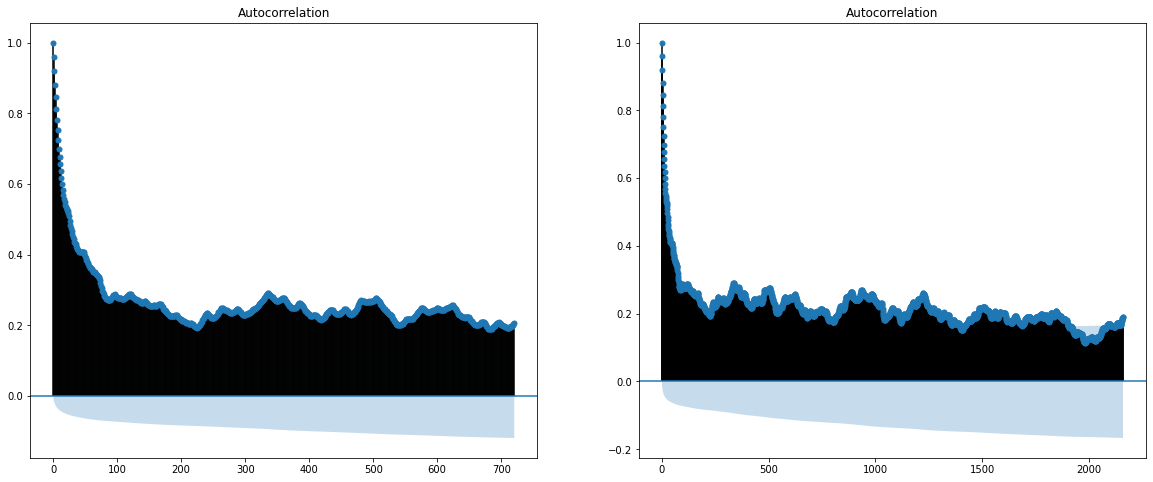

In [203]:
plot_auto_regression(df_interpolated.Wind)

In [204]:
hours_list = ["0{}:00".format(i)  for i in range(10)] + ["{}:00".format(i)  for i in range(10,25)]

In [205]:
useful_columns = df_interpolated.columns[1:]
print(useful_columns[:10])

Index(['Wind_mean', 'Wind_median', 'Wind_max', 'Wind_min', 'Wind_std', 'Hours',
       'Wind', 'guitrancourt_Speed(m/s)', 'guitrancourt_Direction (deg N)',
       'lieusaint_Speed(m/s)'],
      dtype='object')


In [206]:
print(useful_columns[10:20])

Index(['lieusaint_Direction (deg N)', 'lvs-pussay_Speed(m/s)',
       'lvs-pussay_Direction (deg N)', 'parc-du-gatinais_Speed(m/s)',
       'parc-du-gatinais_Direction (deg N)', 'arville_Speed(m/s)',
       'arville_Direction (deg N)', 'boissy-la-riviere_Speed(m/s)',
       'boissy-la-riviere_Direction (deg N)', 'angerville-1_Speed(m/s)'],
      dtype='object')


In [207]:
print(useful_columns[20:30])

Index(['angerville-1_Direction (deg N)', 'angerville-2_Speed(m/s)',
       'angerville-2_Direction (deg N)', 'guitrancourt-b_Speed(m/s)',
       'guitrancourt-b_Direction (deg N)', 'lieusaint-b_Speed(m/s)',
       'lieusaint-b_Direction (deg N)', 'lvs-pussay-b_Speed(m/s)',
       'lvs-pussay-b_Direction (deg N)', 'parc-du-gatinais-b_Speed(m/s)'],
      dtype='object')


In [208]:
print(useful_columns[30:])

Index(['parc-du-gatinais-b_Direction (deg N)', 'arville-b_Speed(m/s)',
       'arville-b_Direction (deg N)', 'boissy-la-riviere-b_Speed(m/s)',
       'boissy-la-riviere-b_Direction (deg N)', 'angerville-1-b_Speed(m/s)',
       'angerville-1-b_Direction (deg N)', 'angerville-2-b_Speed(m/s)',
       'angerville-2-b_Direction (deg N)'],
      dtype='object')


In [209]:
def plot_all_acf(column_name):
    fig, axs = plt.subplots(int(12), 2, figsize=(15, 2*50))

    for hour, ax in zip(hours_list, axs.flatten()):
            plot_acf(df_interpolated[[column_name,"Hours"]][df.Hours==hour][column_name], ax=ax, lags=60)
            ax.set_title('Autocorrelation hour {} with {}'.format(str(hour), column_name) )
            ax.plot(np.linspace(-60,60,120),np.full(120,0.05), 'go--', linewidth=1, markersize=1, color="red")
            ax.plot(np.linspace(-60,60,120),np.full(120,-0.05), 'go--', linewidth=1, markersize=1, color="red")
            ax.plot(np.full(100,-30),np.linspace(-0.1,0.1,100), 'go--', linewidth=1, markersize=1, color="blue")
    plt.plot()
    
def plot_all_pacf(column_name):
    fig, axs = plt.subplots(int(12), 2, figsize=(15, 2*50))
    
    for hour, ax in zip(hours_list, axs.flatten()):
            plot_pacf(df_interpolated[[column_name,"Hours"]][df.Hours==hour][column_name], ax=ax, lags=60)
            ax.set_title('Autocorrelation hour {} with {}'.format(str(hour), column_name) )
            ax.plot(np.full(100,-30),np.linspace(-0.1,0.1,100), 'go--', linewidth=1, markersize=1, color="blue")
    plt.plot()


In [211]:
df_interpolated[['parc-du-gatinais-b_Direction (deg N)',"Hours"]][df.Hours=="00:00"]['parc-du-gatinais-b_Direction (deg N)']

C:\miniconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


96       345.000000
192      173.666667
288      249.333333
384       39.166667
480       76.833333
            ...    
30620    221.400000
30716    229.333333
30812    227.666667
30908     31.333333
31004    279.000000
Name: parc-du-gatinais-b_Direction (deg N), Length: 323, dtype: float64

## Model

In [242]:
pd.DataFrame(normalized_df_column)[df_interpolated.Hours=="00:00"]

,parc-du-gatinais-b_Direction (deg N)
24,0.327547
48,-1.352597
72,0.890438
96,1.724539
120,-1.149615
...,...
30898,-0.305279
30922,-1.550461
30946,1.697248
30970,-0.782883


In [305]:
normalized_df_wind_mean = (df_interpolated["Wind_mean"]-df_interpolated["Wind_mean"].mean())/df_interpolated["Wind_mean"].std()
def plot_diff_day_but_same_hour_ccf(column_name):
    fig, axs = plt.subplots(int(12), 2, figsize=(15, 2*50))
    normalized_df_column = (df_interpolated[column_name]-df_interpolated[column_name].mean())/df_interpolated[column_name].std()
    for hour, ax in zip(hours_list, axs.flatten()):
            ax.xcorr(pd.Series(normalized_df_wind_mean)[df_interpolated.Hours==hour], pd.Series(normalized_df_column)[df_interpolated.Hours==hour], usevlines=True, maxlags=60, normed=True, lw=2 )
            ax.set_title('Cross-correlation hour {} with {}'.format(str(hour), column_name) )
            ax.grid(True)
            ax.plot(np.linspace(-60,60,120),np.full(120,0.05), 'go--', linewidth=1, markersize=1, color="red")
            ax.plot(np.linspace(-60,60,120),np.full(120,-0.05), 'go--', linewidth=1, markersize=1, color="red")
            ax.plot(np.full(100,-30),np.linspace(-0.1,0.1,100), 'go--', linewidth=1, markersize=1, color="blue")
            ax.plot(np.full(100,18),np.linspace(-0.1,0.1,100), 'go--', linewidth=1, markersize=1, color="orange")
    plt.plot()

def plot_continuous_hour_ccf(column_name):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    normalized_df_column = (df_interpolated[column_name]-df_interpolated[column_name].mean())/df_interpolated[column_name].std()
    ax.xcorr(pd.Series(normalized_df_wind_mean), pd.Series(normalized_df_column), usevlines=True, maxlags=60, normed=True, lw=2 )
    ax.set_title('Cross-correlation with {}'.format( column_name) )
    ax.grid(True)
    plt.plot()
    plt.plot(np.linspace(-60,60,120),np.full(120,0.05), 'go--', linewidth=1, markersize=1, color="red")
    plt.plot(np.linspace(-60,60,120),np.full(120,-0.05), 'go--', linewidth=1, markersize=1, color="red")
    plt.plot(np.full(100,-30),np.linspace(-0.1,0.1,100), 'go--', linewidth=1, markersize=1, color="blue")

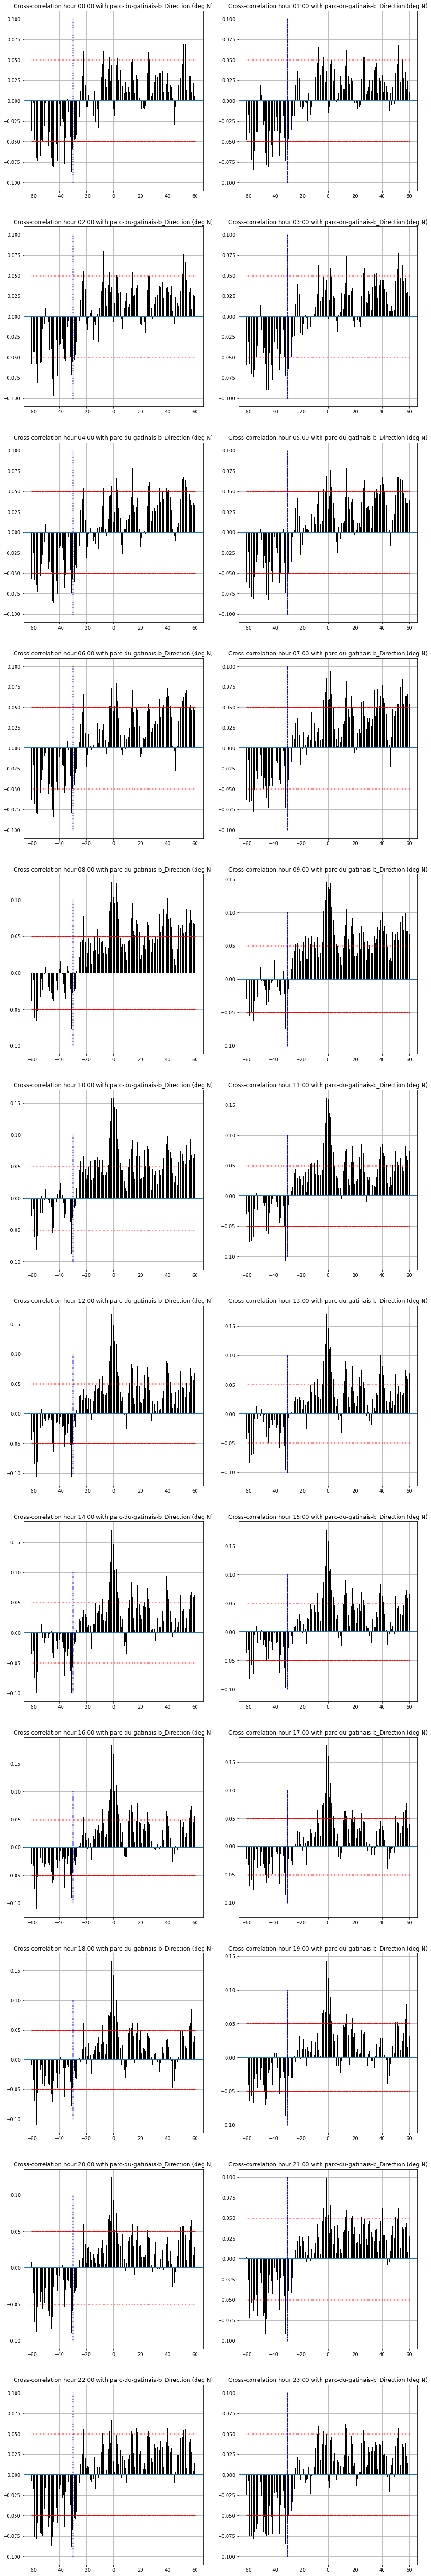

In [306]:
plot_diff_day_but_same_hour_ccf('parc-du-gatinais-b_Direction (deg N)')

array([-60.        , -58.99159664, -57.98319328, -56.97478992,
       -55.96638655, -54.95798319, -53.94957983, -52.94117647,
       -51.93277311, -50.92436975, -49.91596639, -48.90756303,
       -47.89915966, -46.8907563 , -45.88235294, -44.87394958,
       -43.86554622, -42.85714286, -41.8487395 , -40.84033613,
       -39.83193277, -38.82352941, -37.81512605, -36.80672269,
       -35.79831933, -34.78991597, -33.78151261, -32.77310924,
       -31.76470588, -30.75630252, -29.74789916, -28.7394958 ,
       -27.73109244, -26.72268908, -25.71428571, -24.70588235,
       -23.69747899, -22.68907563, -21.68067227, -20.67226891,
       -19.66386555, -18.65546218, -17.64705882, -16.63865546,
       -15.6302521 , -14.62184874, -13.61344538, -12.60504202,
       -11.59663866, -10.58823529,  -9.57983193,  -8.57142857,
        -7.56302521,  -6.55462185,  -5.54621849,  -4.53781513,
        -3.52941176,  -2.5210084 ,  -1.51260504,  -0.50420168,
         0.50420168,   1.51260504,   2.5210084 ,   3.52

In [275]:
np.linspace(0, 10, 1000)

array([ 0.        ,  0.01001001,  0.02002002,  0.03003003,  0.04004004,
        0.05005005,  0.06006006,  0.07007007,  0.08008008,  0.09009009,
        0.1001001 ,  0.11011011,  0.12012012,  0.13013013,  0.14014014,
        0.15015015,  0.16016016,  0.17017017,  0.18018018,  0.19019019,
        0.2002002 ,  0.21021021,  0.22022022,  0.23023023,  0.24024024,
        0.25025025,  0.26026026,  0.27027027,  0.28028028,  0.29029029,
        0.3003003 ,  0.31031031,  0.32032032,  0.33033033,  0.34034034,
        0.35035035,  0.36036036,  0.37037037,  0.38038038,  0.39039039,
        0.4004004 ,  0.41041041,  0.42042042,  0.43043043,  0.44044044,
        0.45045045,  0.46046046,  0.47047047,  0.48048048,  0.49049049,
        0.5005005 ,  0.51051051,  0.52052052,  0.53053053,  0.54054054,
        0.55055055,  0.56056056,  0.57057057,  0.58058058,  0.59059059,
        0.6006006 ,  0.61061061,  0.62062062,  0.63063063,  0.64064064,
        0.65065065,  0.66066066,  0.67067067,  0.68068068,  0.69